# DA-VINCIS: Detection of Aggressive and Violent Incidents from Social Media in Spanish 

## Identificación de incidentes violentos unsando BETO con fine tuning (2022)

The objective of this task is to build models able to determine if a news item obtained from Twitter describes a violent incident or not by analyzing the textual information. (https://sites.google.com/view/davincis-iberlef/home)

This code works for the two subtasks


This Colab was adapted from:
Guillermo Blanco
https://github.com/guibla236/BETO

------------------------------------------------------------------------------

## Binary Classification (Task 1)

### Library installation for downloading and managing pre-trained models

In [ ]:
! pip install --quiet "torchvision" "torch>==1.10" "pytorch-lightning>=1.3" "torchmetrics>=0.3" "typing-extensions<4,>=3.7.4.3" "tf-estimator-nightly==2.8.0.dev2021122109" "folium==0.2.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 456.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.2/826.2 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 22.7 MB/s

In [ ]:
%%capture
!pip install transformers # pre-trained models from https://huggingface.co/

### Import all the libraries and functions we will use

In [ ]:
import re
import torch
import os
import torch.optim
import time
import datetime
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import  BertTokenizer
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.metrics import confusion_matrix
from torchmetrics import Accuracy #if you needed
from torchmetrics import F1Score #if you needed

### Select the device where the model is to be trained.


In [ ]:
run_on = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(run_on)
device

device(type='cuda')

### Dataset
You must have a copy of the data in your own drive directory in a folder named DAVINCIS the folder should have the following structure:

Test/

  ├─ test_data.csv //when available in the final phase

Train/

  ├─ train_labels_subtask_1.csv

  ├─ train_labels_subtask_2.csv

  ├─ train_data.csv

  ├─ trial_labels_subtask_1.csv

  ├─ trial_labels_subtask_2.csv

  ├─ trial_data.csv

Validation/

  ├─ validation_data.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#training data
#dfTexts = pd.read_csv('/content/drive/MyDrive/DAVINCIS/Train/train_data.csv', names=['description'],header=None)
#dfLabels = pd.read_table('/content/drive/MyDrive/DAVINCIS/Train/train_labels_subtask_1.csv', names=['Incident'],header=None)
dfTexts = pd.read_csv('train_data.csv', names=['Image', 'description'], header=None) #, encoding='latin1')
dfLabels = pd.read_table('train_labels_subtask_1.csv', names=['Incident'], header=None)

d = {'Category':dfLabels['Incident'].values, 'Text':dfTexts['description'].values}
df = pd.DataFrame(data=d)

pd.set_option('display.max_colwidth',None)
df.head(5)

,Category,Text
0,0,Morales: #EEUU “sufrió una derrota vergonzosa” ante el terrorismo y el narcotráfico #NarcoterrorismoDoméstico https://t.co/GCenoztH3H https://t.co/WMF36c68i3
1,0,"Tus acciones te hacen ser una bella persona, no tu color de piel o tu dinero, esa joven con su hermoso gesto me robo el corazon. https://t.co/wXfw2Hrqv7"
2,1,"#Seguridad 🚨🛑 Detuvo policía municipal a dos hombres por robo a casa habitación, en #Puebla. En la acción se recuperaron computadoras portátiles, un equipo de audio, un dispositivo de comunicación móvil, entre otros artículos. Urbano| Noticias https://t.co/xXKSnVjz8k... https://t.co/HcoPbEpPLk"
3,0,20 años del accidente que convirtió a Alex Zanardi en leyenda. https://t.co/TALvr20hB5
4,0,"¡Llega el castigo para Max Verstappen! El neerlandés tendrá tres posiciones de sanción en la parrilla de salida del #RussianGP, tras el accidente que protagonizó con Lewis Hamilton en el #ItalianGP ¿Qué opinan de la decisión de la FIA? | #F1 https://t.co/yfUlLPzcGL"


[]

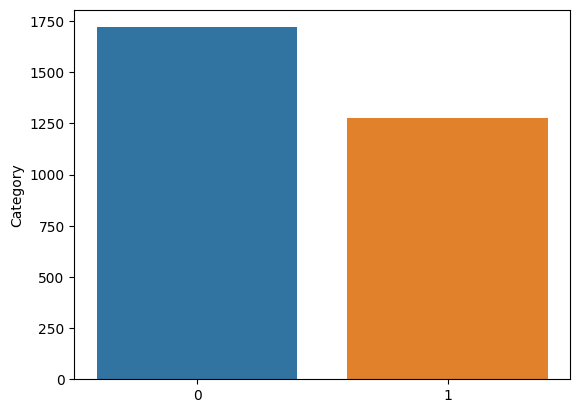

In [ ]:
#class distribution
counts = df['Category'].value_counts()
ax = sns.barplot(x=df['Category'].unique(), y=counts)
ax.plot()

### Assembling training and validation partitions

In [ ]:
# Extract the columns from the dataframe
features = df['Text']
labels = df['Category']

X_train, X_val, y_train, y_val = train_test_split(features, labels)

# Partition sizes
print('Number of training set samples : {}'.format(len(X_train)))
print('Number of validation set samples : {}'.format(len(X_val)))

Number of training set samples : 2247
Number of validation set samples : 749


### Tokenization 

This process consists of transforming the words of the messages into features expected by BETO.
- We tentatively set the maximum size of a message to 128 tokens.


In [ ]:
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased",
                                          do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []

    for doc in dataset:
      encoded_doc = tokenizer.encode_plus(doc,
                                          add_special_tokens=True,
                                          max_length=128,
                                          truncation=True,
                                          padding="max_length")
        
      input_ids.append(encoded_doc['input_ids'])
      attention_mask.append(encoded_doc['attention_mask'])

    return (torch.tensor(input_ids), torch.tensor(attention_mask))

# We tokenize training and validation partitions
X_train_inputs, X_train_masks = preprocessing(X_train)
X_val_inputs, X_val_masks = preprocessing(X_val)

# We calculate the maximum number of words per message 
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Maximum number of tokens in training messages {0}'.format(max_len))

Maximum number of tokens in training messages 128


To optimize the learning process, the data sets are divided into batches of 32 samples. This allows the updating of model parameters to be more accurate, which also serves to attack the problem of *overfitting*.
The data is then adapted so that it can be properly processed by 
PyTorch (the library in charge of model training).

In [ ]:
# Data loaders
batch_size = 32

y_train_labels = torch.tensor(y_train.values)
y_val_labels = torch.tensor(y_val.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler,
                 batch_size=batch_size,
                 num_workers=0)
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks,
                   y_train_labels)
val_dataloader = dataloader(X_val_inputs, X_val_masks, 
                 y_val_labels)

Set a random seed to ensure that the results are reproducible when attempting to run this *notebook* again.

In [ ]:
# set random seed
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed_all(value)
set_seed(42)


Set BETO parameters to perform fine tuning 

In [ ]:
# Create model and optimizer
model = BertForSequenceClassification.from_pretrained(
        "dccuchile/bert-base-spanish-wwm-cased",
         num_labels=2,
         output_attentions=False,
         output_hidden_states=False)

optimizer = AdamW(model.parameters(),
                  lr = 4e-5,
                  eps = 1e-6
                  )

if run_on == 'cuda':
    model.cuda()

# Define number of epochs
epochs = 3

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
            num_warmup_steps = 0, 
            num_training_steps = total_steps)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Accessory functions to measure and format the delay of each training epoch and to compute the accuracy of the model parameters in attempting to predict the labels of the validation set.

In [ ]:
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#variable to plot the confusion matrix
conf = []

### Training

Training and validation function for each epoch.

In [ ]:
def training(n_epochs, training_dataloader,
             validation_dataloader):
    # ========================================
    #               Training 
    # ========================================
    print('======= Training =======')

    max_step_t = len(training_dataloader)
    max_step_v = len(validation_dataloader)
    acc=F1Score(task='binary')

    for epoch_i in range(0,n_epochs):
        # for each epoch...
        print("")
        print('======= Epoch {:} / {:} ======='.format(
             epoch_i + 1, epochs))
        # We save the start time to see how long it takes.
        t0 = time.time()
        # We reset the loss value for each epoch.
        total_loss = 0
        # We put the model in training mode.
        model.train()

        # For each subset (minibatch) of the training set:
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            # We disarm the dataloader in:
             # [0]: input ids (indexes in the BETO token dictionary),
             # [1]: attention masks (how much attention is given to each token in the sentence),
             # [2]: labels (the result that should be returned: the data y)
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            # We clean the gradients for the present batch
            model.zero_grad()

            # Propagation forward in the layers
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            # We calculate the loss of the present minibatch
            loss = outputs[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Backpropagation
            loss.backward()

            #(this prevents the gradient from becoming explosive)
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                            1.0)

            # We update the parameters
            optimizer.step()
            scheduler.step()
            if step %50 == 0 or step==max_step_t:
              print('Nº Batch: {0}/{1} | batch loss: {2} | avg loss: {3}'.format(step,
                                                                                max_step_t,
                                                                                batch_loss,
                                                                                total_loss/(step+1)))
        # We calculate the average loss in the current epoch of the training set
        avg_train_loss = total_loss / len(train_dataloader)


        print("")
        print("  Average training loss: {0:.2f}".
             format(avg_train_loss))
        print("  Training epoch took: {:}".format(
              format_time(time.time() - t0)))

        # ========================================
        #               Validation
        # ========================================
        # After training for an epoch, we measure their ability to predict.

        print("")
        print("======= Validation =======")

        t0 = time.time()

        # We put the model in validation mode
        model.eval()

        # We declare variables
        eval_loss, eval_accuracy = 0, 0
        all_logits = []
        all_labels = []

        # We evaluate the data by minibatches
        for step, batch in enumerate(validation_dataloader):
            
            # We repeat the process of dividing the dataloader data
             # and upload them to the device that will do the validation.
             #[0]: input ids,
             #[1]: attention masks,
             #[2]: labels

            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # We don't want the model to compute gradients
            with torch.no_grad():
                # We generate the predictions of the model
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

            # ...we extract them
            logits = outputs[0]

            # We move the logits (data prior to the activation function) to the CPU
            logits = logits.detach().cpu()
            b_labels = b_labels.to('cpu')

            # Guardamos los logits y las etiquetas
            # They will be useful for the confusion matrix.
            predict_labels = np.argmax(
                             logits, axis=1).flatten()
            all_logits.extend(predict_labels.tolist())
            all_labels.extend(b_labels.tolist())

            # We calculate the accuracy of this batch
            tmp_eval_accuracy = (predict_labels == b_labels).sum()/predict_labels.shape[0]

            # We calculate the cumulative accuracy up to the current epoch.
            eval_accuracy += tmp_eval_accuracy

        # We show the final accuracy for this epoch
        print("  Accuracy: {0:.2f}".
              format(eval_accuracy / (step+1)))
        print("  Validation took: {:}".format(
             format_time(time.time() - t0)))

    # We show the confusion matrix
    conf = confusion_matrix(
           all_labels, all_logits, normalize='true')
    print("")
    print("Training complete")
    return conf

In [ ]:
conf = training(epochs, train_dataloader, val_dataloader)

======= Training =======

======= Epoch 1 / 3 =======
Nº Batch: 0/71 | batch loss: 0.7466301918029785 | avg loss: 0.7466301918029785
Nº Batch: 50/71 | batch loss: 0.3488510847091675 | avg loss: 0.33065394881893606

  Average training loss: 0.30
  Training epoch took: 0:00:44

======= Validation =======
  Accuracy: 0.93
  Validation took: 0:00:05

======= Epoch 2 / 3 =======
Nº Batch: 0/71 | batch loss: 0.4549599885940552 | avg loss: 0.4549599885940552
Nº Batch: 50/71 | batch loss: 0.06508630514144897 | avg loss: 0.1603442217935534

  Average training loss: 0.15
  Training epoch took: 0:00:44

======= Validation =======
  Accuracy: 0.95
  Validation took: 0:00:05

======= Epoch 3 / 3 =======
Nº Batch: 0/71 | batch loss: 0.3019869923591614 | avg loss: 0.3019869923591614
Nº Batch: 50/71 | batch loss: 0.01954953372478485 | avg loss: 0.05076362907101272

  Average training loss: 0.05
  Training epoch took: 0:00:46

======= Validation =======
  Accuracy: 0.95
  Validation took: 0:00:05

Trai

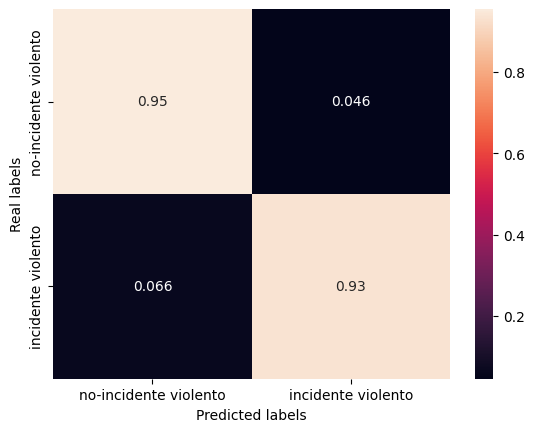

In [ ]:
ticks = ['no-incidente violento', 'incidente violento']
ax = sns.heatmap(conf, annot=True, xticklabels=ticks, yticklabels=ticks)
ax.set(xlabel='Predicted labels', ylabel='Real labels')
plt.show()

### Predictions on evaluation set

For the moment only validation partition has been released, we will use this set to evaluate our BETO model.




In [ ]:
def classify_incident(message):
  encoding_txt = tokenizer.encode_plus(
      message,
      max_length = 128,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      padding="max_length",
      return_attention_mask = True,
      return_tensors = 'pt'
      )
  
  input_ids = encoding_txt['input_ids'].to(device)
  attention_mask = encoding_txt['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output.logits, dim=1)
  
  return prediction.item()


In [ ]:
#dfTestTexts = pd.read_csv('/content/drive/MyDrive/DAVINCIS/Validation/validation_data.csv',names=['description'],header=None)
dfTestTexts = pd.read_csv('validation_data.csv', names=['images', 'description'], header=None)
pd.set_option('display.max_colwidth', None)
dfTestTexts.head(5)

,images,description
0,['E_C3M6fXoAY1JxD.jpg'],Accidente en Transversal 93 #traficobogota. Tráfico avanzando21m más lento de lo habitual. https://t.co/A6p7moOa2J https://t.co/sYFuUXBUSc
1,['E_GnWRxWQAYoHWm.jpg'],"#Entérate #México / #PrecauciónVial en #Tlaxcala se registra cierre intermitente de circulación por accidente, aproximadamente en el km 034+500 autopista (117) Ent. (Aut. México-#Puebla)-#Ocotoxco, mismo tramo, dirección #Huamantla. Atienda indicación vial #EnlaceCiudadano https://t.co/ZezNXkRNcU"
2,['E_LoqrgWQAEiSXH.png'],"#Tecomán es el municipio con mayor incidencia del delito de #Secuestro en #Colima, en el municipio se registraron 17 de los 37 casos que reportó el estado. @WallaceIsabel @nachoperaltacol @FiscaliaColima @colimaaldia https://t.co/yqowLIWmJd"
3,['E_REM3LXIAU_Oy-.jpg'],Asesinato del abogado Enrique Pacheco afuera de su casa - https://t.co/Q0vu0kGw1f https://t.co/Q88whxXTlp
4,['E_WEnAEXMAIANwq.jpg'],"#EducacionQR: Existen muchos mitos y realidades alrededor de la violencia sexual infantil. Para saber más sobre cómo prevenirla, atenderla y erradicarla conoce la “Cartilla de Derechos de las Víctimas de Violencia Sexual Infantil”. Descargar: … https://t.co/FAuRpdHs08"


In [ ]:
y_test_hat = []

for index, row in dfTestTexts.iterrows():
    y_test_hat.append(classify_incident(row["description"]))

In [ ]:
result=pd.DataFrame(list(map(np.ravel, y_test_hat)),columns=['incidents'])
result

,incidents
0,1
1,1
2,0
3,1
4,0
...,...
577,1
578,1
579,1
580,0


### Save & download

At the end we save the results and they are downloaded in the format to participate in codalab. 

JUST UPLOAD THE RESULTING ZIP FILE IN THE CORRESPONDING SITE FOR SUBTASK1

In [ ]:
from google.colab import files
result.to_csv('result1.csv', index=False, header=None)
!zip -r '/content/Task1.zip' 'result1.csv'
files.download('/content/Task1.zip')

  adding: result1.csv (deflated 87%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Multilabel classification (Task 2)



--------------------------------------------------------------------------------

### Clean
We clean the cache of the previous model.

In [ ]:
#if a model is alredy in gpu
import gc

model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### Dataset
You must have a copy of the data in your own drive directory in a folder named DAVINCIS the folder should have the following structure:

Test/

  ├─ test_data.csv //when available in the final phase

Train/

  ├─ train_labels_subtask_1.csv

  ├─ train_labels_subtask_2.csv

  ├─ train_data.csv

  ├─ trial_labels_subtask_1.csv

  ├─ trial_labels_subtask_2.csv

  ├─ trial_data.csv

Validation/

  ├─ validation_data.csv

In [ ]:
#dfTexts = pd.read_csv('/content/drive/MyDrive/DAVINCIS/Train/train_data.csv',names=['description'],header=None)
#dfLabels = pd.read_table('/content/drive/MyDrive/DAVINCIS/Train/train_labels_subtask_2.csv', delimiter=',',header=None)
dfTexts = pd.read_csv('train_data.csv',names=['Images', 'description'], header=None, encoding = 'latin1')
dfLabels = pd.read_table('train_labels_subtask_2.csv', delimiter=',',header=None)

d = {'Categories':dfLabels.values.tolist(), 'Text':dfTexts['description'].values}
df = pd.DataFrame(data=d)

pd.set_option('display.max_colwidth',None)
df.head(5)

,Categories,Text
0,"[0, 0, 0, 1]",Morales: #EEUU ?sufri¢ una derrota vergonzosa? ante el terrorismo y el narcotr fico #NarcoterrorismoDomstico https://t.co/GCenoztH3H https://t.co/WMF36c68i3
1,"[0, 0, 0, 1]","Tus acciones te hacen ser una bella persona, no tu color de piel o tu dinero, esa joven con su hermoso gesto me robo el corazon. https://t.co/wXfw2Hrqv7"
2,"[0, 0, 1, 0]","#Seguridad ???? Detuvo polic¡a municipal a dos hombres por robo a casa habitaci¢n, en #Puebla. En la acci¢n se recuperaron computadoras port tiles, un equipo de audio, un dispositivo de comunicaci¢n m¢vil, entre otros art¡culos. Urbano| Noticias https://t.co/xXKSnVjz8k... https://t.co/HcoPbEpPLk"
3,"[0, 0, 0, 1]",20 a¤os del accidente que convirti¢ a Alex Zanardi en leyenda. https://t.co/TALvr20hB5
4,"[0, 0, 0, 1]","­Llega el castigo para Max Verstappen! El neerlands tendr tres posiciones de sanci¢n en la parrilla de salida del #RussianGP, tras el accidente que protagoniz¢ con Lewis Hamilton en el #ItalianGP ¨Qu opinan de la decisi¢n de la FIA? | #F1 https://t.co/yfUlLPzcGL"


[]

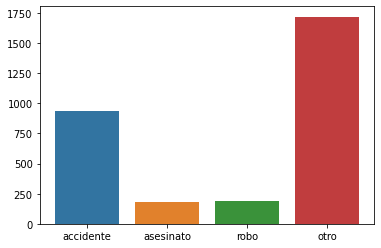

In [ ]:
#class distribution
categories = df['Categories']
counts=[categories.apply(lambda x: x[i]).sum() for i in range(4)]
x=['accidente', 'asesinato', 'robo', 'otro']
ax = sns.barplot(x=x, y=counts)
ax.plot()

In [ ]:
# Extract the columns from the dataframe
features = df['Text']
#labels = df['Categories']
labels = categories

X_train, X_val, y_train, y_val = train_test_split(features, labels)

# Partition sizes
print('Number of training set samples : {}'.format(len(X_train)))
print('Number of validation set samples : {}'.format(len(X_val)))

Number of training set samples : 2521
Number of validation set samples : 841


### Tokenization
This process consists of transforming the words of the messages into features expected by BETO.
- We tentatively set the maximum size of a message to 128 tokens.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased",
                                          do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []

    for doc in dataset:
      encoded_doc = tokenizer.encode_plus(doc,
                                          add_special_tokens=True,
                                          max_length=128,
                                          truncation=True,
                                          padding="max_length")
        
      input_ids.append(encoded_doc['input_ids'])
      attention_mask.append(encoded_doc['attention_mask'])

    return (torch.tensor(input_ids), torch.tensor(attention_mask))

# We tokenize training and validation partitions
X_train_inputs, X_train_masks = preprocessing(X_train)
X_val_inputs, X_val_masks = preprocessing(X_val)

# We calculate the maximum number of words per message 
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Maximum number of tokens in training messages {0}'.format(max_len))

Maximum number of tokens in training messages 128


In [ ]:
# Data loaders
batch_size = 32

y_train_labels = torch.stack([torch.tensor(lista) for lista in y_train.values]).to(torch.float)
y_val_labels = torch.stack([torch.tensor(lista) for lista in y_val.values]).to(torch.float)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler,
                 batch_size=batch_size,
                 num_workers=0)
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks,
                   y_train_labels)
val_dataloader = dataloader(X_val_inputs, X_val_masks, 
                 y_val_labels)

In [ ]:
# set random seed
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed_all(value)
set_seed(42)

In [ ]:
# Create model and optimizer
model = BertForSequenceClassification.from_pretrained(
        "dccuchile/bert-base-spanish-wwm-cased",
         num_labels=5,
         output_attentions=False,
         output_hidden_states=False)

optimizer = AdamW(model.parameters(),
                  lr = 4e-5,
                  eps = 1e-6
                  )

if run_on == 'cuda':
    model.cuda()

# Define number of epochs
epochs = 3

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
            num_warmup_steps = 0, 
            num_training_steps = total_steps)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [ ]:
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#variable to plot the confusion matrix
conf = []

### Training

In [ ]:
def training(n_epochs, training_dataloader,
             validation_dataloader):
    # ========================================
    #               Training 
    # ========================================
    print('======= Training =======')

    max_step_t = len(training_dataloader)
    max_step_v = len(validation_dataloader)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    acc=Accuracy(task = 'multiclass', average='macro', num_classes=2, mdmc_average='samplewise')

    for epoch_i in range(0,n_epochs):
        print("")
        print('======= Epoch {:} / {:} ======='.format(
             epoch_i + 1, epochs))
        t0 = time.time()
        total_loss = 0
        model.train()
        
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            model.zero_grad()

            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            )

            loss = loss_fn(outputs[0], b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

            optimizer.step()
            scheduler.step()
            if step %50 == 0 or step==max_step_t:
              print('Nº Batch: {0}/{1} | batch loss: {2} | avg loss: {3}'.format(step,
                                                                                max_step_t,
                                                                                batch_loss,
                                                                                total_loss/(step+1)))

        avg_train_loss = total_loss / len(train_dataloader)

        print("")
        print("  Average training loss: {0:.2f}".
             format(avg_train_loss))
        print("  Training epoch took: {:}".format(
              format_time(time.time() - t0)))

        # ========================================
        #               Validation
        # ========================================

        print("")
        print("======= Validation =======")

        t0 = time.time()

        model.eval()

        eval_loss, eval_accuracy = 0, 0
        all_logits = []
        all_labels = []
        total=0.
        correct = 0.

        for step, batch in enumerate(validation_dataloader):

            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            with torch.no_grad():
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

            logits = outputs[0]

            logits = logits.detach().cpu()
            b_labels = b_labels.int().to('cpu')

            predict_labels = torch.round(torch.sigmoid(logits)).int()

            tmp_eval_accuracy = sum([torch.equal(predict_labels[i],b_labels[i]) for i in range(b_labels.shape[0])])/b_labels.shape[0]

            eval_accuracy += tmp_eval_accuracy

        print("  Accuracy: {0:.2f}".
              format(eval_accuracy / (step+1)))
        print("  Validation took: {:}".format(
             format_time(time.time() - t0)))

    print("")
    print("Training complete")


In [ ]:
conf = training(epochs, train_dataloader, val_dataloader)

======= Training =======

======= Epoch 1 / 3 =======
Nº Batch: 0/79 | batch loss: 0.6960155367851257 | avg loss: 0.6960155367851257
Nº Batch: 50/79 | batch loss: 0.25897613167762756 | avg loss: 0.3468625095545077

  Average training loss: 0.32
  Training epoch took: 0:00:52

======= Validation =======
  Accuracy: 0.65
  Validation took: 0:00:06

======= Epoch 2 / 3 =======
Nº Batch: 0/79 | batch loss: 0.2386290282011032 | avg loss: 0.2386290282011032
Nº Batch: 50/79 | batch loss: 0.2025231122970581 | avg loss: 0.25850479480098276

  Average training loss: 0.24
  Training epoch took: 0:00:51

======= Validation =======
  Accuracy: 0.69
  Validation took: 0:00:06

======= Epoch 3 / 3 =======
Nº Batch: 0/79 | batch loss: 0.1872541308403015 | avg loss: 0.1872541308403015
Nº Batch: 50/79 | batch loss: 0.1414724439382553 | avg loss: 0.21802865392437168

  Average training loss: 0.21
  Training epoch took: 0:00:51

======= Validation =======
  Accuracy: 0.71
  Validation took: 0:00:06

Train

### Predictions on evaluation set

In [ ]:
def classify_incident(message):
  encoding_txt = tokenizer.encode_plus(
      message,
      max_length = 128,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      padding="max_length",
      return_attention_mask = True,
      return_tensors = 'pt'
      )
  model.eval()
  with torch.no_grad():
    input_ids = encoding_txt['input_ids'].to(device)
    attention_mask = encoding_txt['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
  
  return np.round(torch.sigmoid(output[0]).cpu().numpy())[0].astype(int)

In [ ]:
#dfTestTexts = pd.read_csv('/content/drive/MyDrive/DAVINCIS/Validation/validation_data.csv', header=None, names=['description'])
dfTestTexts = pd.read_csv('validation_data.csv', header=None, names=['description'])
pd.set_option('display.max_colwidth',None)
dfTestTexts.head(5)

,description
0,"#17Sep #Miranda #Trafico @Edward_Alfonso: Reportan fuerte cola en el kilómetro 06, sentido Caracas por un accidente con vehículo. https://t.co/Dz73GaFvLi"
1,"Nacionales - Nueva Hidalgo* - Accidente de autobus y un carro azul en la autopista México Nueva Hidalgo, hasta el momento no se registró ningún herido solamente hubo daños materiales a las unidades. https://t.co/joorsMSDXO"
2,Con el asesinato del Socialista Salvador Allende y su Gobierno (GdE Chile 11/Sep/1973) nació el Neoliberalismo en Chile y América Latina. Con el fortalecimiento del Socialismo en América Latina inicia el fin del Neoliberalismo en Chile. ¡Allende Vive! 🖤❤️✊🏻 https://t.co/dwoX57yt7H
3,Accidente en MEX-150 / Puebla - Tehuacán #PueblaTrafico. Tráfico moviéndose 8m más lento de lo normal. https://t.co/HgcE19kfoj https://t.co/7jTyaPNFEU
4,Combate Gobierno de Benito Juárez violencia de género - https://t.co/SrxjkWDYFx https://t.co/BuuOlYBwxD


In [ ]:
y_test_hat = []

for index, row in dfTestTexts.iterrows():
    y_test_hat.append(classify_incident(row["description"]))

In [ ]:
result=pd.DataFrame(list(map(np.ravel, y_test_hat)),columns=['accidente','homicidio','ninguno','robo','secuestro'])
result

,accidente,homicidio,ninguno,robo,secuestro
0,1,0,0,0,0
1,1,0,0,0,0
2,0,0,1,0,0
3,1,0,0,0,0
4,0,0,1,0,0
...,...,...,...,...,...
669,0,0,1,0,0
670,1,0,0,0,0
671,1,0,0,0,0
672,1,0,0,0,0


### Save & download

At the end we save the results and they are downloaded in the format to participate in codalab. 

JUST UPLOAD THE RESULTING ZIP FILE IN THE CORRESPONDING SITE FOR SUBTASK2

IMPORTANT: Please make sure that you make at least a positive prediction for each subclass


In [ ]:
from google.colab import files
result.to_csv('result2.csv', index=False, header=None)
!zip -r '/content/Task2.zip' 'result2.csv'
files.download('/content/Task2.zip') 

  adding: result2.csv (deflated 94%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
trial = pd.read_csv('trial_data.csv', names=['description'],header=None)
dfLabels = pd.read_table('trial_labels_subtask_2.csv', delimiter=',',header=None)

d = {'Categories':dfLabels.values.tolist(), 'Text':trial['description'].values}
df = pd.DataFrame(data=d)

pd.set_option('display.max_colwidth',None)
df.head(5)

,Categories,Text
0,"[1, 0, 0, 0, 0]",Accidente en el Vallado frente al polideportivo; 2 motos y un bus #TráficoCali #Cali https://t.co/SXtotJzir0
1,"[0, 0, 1, 0, 0]",Vitor Belfort abruma a Evander Holyfield en la victoria por nocaut técnico en el primer asalto https://t.co/b5S3U0XE2w https://t.co/HoV6xdMfjZ
2,"[0, 0, 1, 0, 0]","En México, las estadísticas de violencia homicida y de inseguridad están en alza casi constante desde 2006. La política pública no ha encontrado la solución a la violencia. ¿Por qué están funcionando las estrategias de seguridad? ✍🏻 @romainlecour https://t.co/2kOc58Ky3V https://t.co/qrQ5K1gKP4"
3,"[0, 1, 0, 0, 0]","Como Jorge Armando Ayala Guarín de 25 años, fue identificada la persona asesinada por dos venezolanos en #Piedecuesta . #Santander. Los responsables de este homicidio fueron identificados como Alberto Rafael Sala Figueroa y Edgardo Rafael Garcia Goita. https://t.co/BPHm0Kj9Ji https://t.co/wOR9GbcJ5u"
4,"[0, 0, 1, 0, 0]",Quebrar un vidrio ///// Quebrar el país a plomo y asalto. En fin... La berraquera mi Colombia. https://t.co/PATYP4tLuD


[]

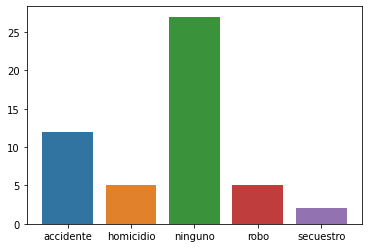

In [ ]:
#class distribution
categories = df['Categories']
counts=[categories.apply(lambda x: x[i]).sum() for i in range(5)]
x=['accidente','homicidio','ninguno','robo','secuestro']
ax = sns.barplot(x=x, y=counts)
ax.plot()

In [ ]:
for count, event in zip(counts, x):
    print(f'Número de tweets del evento {event}: {count}')

Número de tweets del evento accidente: 12
Número de tweets del evento homicidio: 5
Número de tweets del evento ninguno: 27
Número de tweets del evento robo: 5
Número de tweets del evento secuestro: 2
